In [1]:
from kevlib import common_import_script
%run $common_import_script

from astropy import constants as const
from lmfit.models import VoigtModel, ConstantModel
from scipy.stats import norm
from lmfit import Model
from astropy import log
from astropy.io import fits
import csaps
import pandas as pd
import os
from glob import glob
from loadspec import *
from absorber_utils_v4_Copy1 import *
import numpy as np
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
import pandas as pd
from astropy.table import Table
from astropy import units as u
from astropy import constants as const
from loadspec import *

from absorber_utils_v4 import *

np.random.seed(1337)

print("finished!")

/media/rd1/kwillis/kevlib_dev/src/kevlib/common_imports.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange  # 231010


---------------------------------------------------------------------------------------
|                        Last run date: 2023-10-25 09:00 PM E                         |
---------------------------------------------------------------------------------------
| Python | Jupyterlab | Numpy  | Scipy  | Astropy | Matplotlib | Tensorflow | Pytorch |
---------------------------------------------------------------------------------------
| 3.11.4 |   4.0.5    | 1.24.3 | 1.11.1 |  5.3.1  |   3.7.2    |   2.14.0   |  2.0.1  |
---------------------------------------------------------------------------------------


2023-10-25 21:00:17.479265: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 21:00:17.479306: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 21:00:17.479350: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 21:00:17.486692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 21:00:18.286322: W tensorflow/c

finished!


In [2]:
catalog_DR9 = np.loadtxt("../dla_ml/data_dr9/DR9DLAcatalog.txt")

In [3]:
from astroquery.sdss import SDSS
from kevlib.utils import robust_fit

def get_spectra(n):
    
    plate = catalog_DR9[:,1][n]
    mjd = catalog_DR9[:,2][n]
    fiber = catalog_DR9[:,3][n]
    redshift = catalog_DR9[:,7][n]

    spectrum = SDSS.get_spectra(plate = plate, fiberID = fiber)
    data = spectrum[0][1].data
    wavelength = 10 ** data['loglam']
    wavelength = wavelength / (redshift + 1)
    flux = data['flux']

    cut = (wavelength > 1195) & (wavelength < 1235)
    wavelength = wavelength[cut]
    flux = flux[cut]

    # __, flux_continuum, __ = robust_fit(wavelength, flux, ** robust_fit_kwargs)

    # flux = flux / flux_continuum
    return wavelength, flux, plate, fiber

4389.0 154.0


/opt/anaconda_2023/envs/py311/lib/python3.11/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


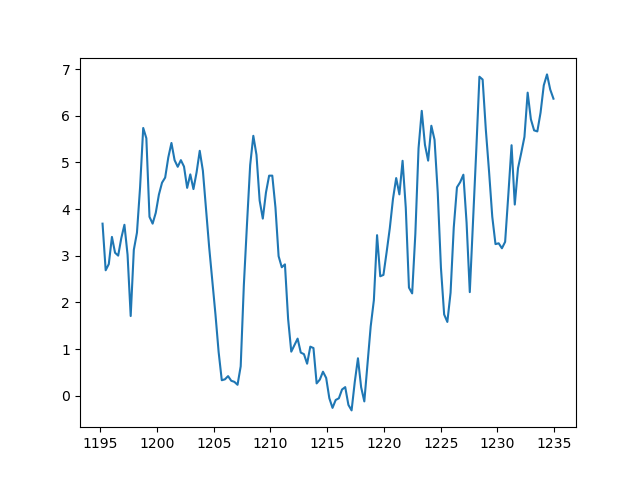

In [4]:
# wavelength, flux, plate, fiber = get_spectra(3)
wavelength, flux, plate, fiber = get_spectra(3)
print(plate, fiber)
plt.figure()
plt.plot(wavelength, flux)

In [5]:
catalog  = np.loadtxt("./data/absorption_line_check.txt")
plate = catalog[:,0]
fiber = catalog[:,1]
mjd = catalog[:,2]
zqso = catalog[:,3]
zabs = catalog[:,4]

del catalog
index = (1 + zqso) * (1215.16 - 15) > 4000
mjd = mjd[index]
plate = plate[index]
fiber = fiber[index]
zqso = zqso[index]
print('Catalog length =', len(zqso))

Catalog length = 20823


In [6]:
wl_rest_template = np.arange(1215.67 - 20, 1215 + 20 + 0.28, 0.28)

In [28]:
def voight(lambda0, gamma, f, N, b, vel, Cf, wv):
    z = vel2shift(vel)
    wv_r = wv / (1.0 + z)
    flux = (1.0 - Cf) + Cf * np.exp( -voigt_tau(lambda0, gamma, f, 10**N, b, wv_r) )
    return flux

def voigt_passthough(x, lambda0, gamma, f, N, b, vel, Cf): #x = independent variable/the spectra array?
    return voigt(lambda0, gamma, f, N, b, vel, Cf, wv=x)

from rbvfit import rb_setline as rb
line_cent = 1215
s = rb.rb_setline(line_cent, method = 'closest')
print(s)

model = Model(voigt_passthough)
params = model.make_params()
params

{'wave': 1215.3394, 'fval': 0.4165, 'name': 'DI 1215', 'gamma': 627000000.0}


name,value,initial value,min,max,vary
lambda0,-inf,None,-inf,inf,True
gamma,-inf,None,-inf,inf,True
f,-inf,None,-inf,inf,True
N,-inf,None,-inf,inf,True
b,-inf,None,-inf,inf,True
vel,-inf,None,-inf,inf,True
Cf,-inf,None,-inf,inf,True


In [30]:
hydrogen_wavelength = 1216 
params['b'].set(vary = True, value = 80.000001, min = 0.0, max = 300.0)
params['lambda0'].set(vary = False, value = hydrogen_wavelength)
params['gamma'].set(vary = False, value = 6.27 * (10**7.5))
params['f'].set(vary = False, value = 0.4165)
params['vel'].set(vary = True, value = 0) #offset redshift
params['Cf'].set(vary = False, value = 1) #continuum
params['N'].set(vary = True, value = 20.8) #column density log[cm^-2]
absorption_flux = model.eval(params, x = wl_rest_template)

In [33]:
def get_spectra_test(i, plots = False, array = False):
    from kevlib.io.sdss import load_sdss_spectrum
    from kevlib.utils.base_defs import robust_fit

    robust_fit_kwargs = dict(
        ubm = 20,
        sdms = np.linspace(15, 0.2, 20), 
        smooth_strength = 0.9, 
        pdeg = 4, 
        fit_type = 'ss',
        plot_q = False,
    )
    
    z_abs = zqso[i]
    
    wl, flux, ferr, ra, dec = load_sdss_spectrum(
        plate = int(plate[i]),
        mjd = int(mjd[i]),
        fiber = int(fiber[i]),
    )

    plate_ = int(plate[i])
    mjd_ = int(mjd[i])
    fiber_ = int(fiber[i])
    
    wl_obs, flux, ferr = wl.value, flux.value, ferr.value

    wl_rest = wl_obs / (z_abs + 1)

    gi = (wl_rest > wl_rest_template[0]) & (wl_rest < wl_rest_template[-1])
    
    flux = np.interp(wl_rest_template, wl_rest, flux)
    ferr = np.interp(wl_rest_template, wl_rest, ferr)

    __, flux_continuum, __ = robust_fit(wl_rest_template, flux, ** robust_fit_kwargs)
    
    flux_norm = flux / flux_continuum
    ferr_norm = ferr / flux_continuum

    if plots == True:
    
        plt.figure(figsize = (5, 3))
        plt.title("plate: " + str(plate[i]) + ", fiber: " + str(fiber[i]) + ", mjd: "  + str(mjd[i]))
        plt.plot(wl_rest_template, absorption_flux, color = "pink", alpha = 1, label = "column density: 20.8")
        plt.plot(wl_rest_template, flux_norm, color = "black", linewidth = 0.5, label = "i: 17779 (SDSS positive)")
        plt.axvline(x = 1215.3, color = "purple" , linestyle = '--', label = 'absorption line')
        plt.legend()

    if array == True:
        return flux_norm

    # return flux_norm, plate[i], fiber[i], mjd[i]

/media/rd1/kwillis/kevlib_dev/src/kevlib/io/sdss.py:156: RuntimeWarning: divide by zero encountered in power
  ferr = hdul[1].data[fiber - 1, :]**(-0.5) * sdss_flux_unit # To standard deviation


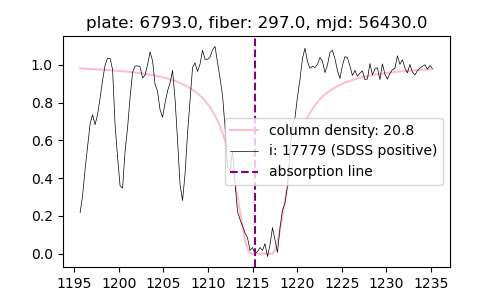

In [34]:
get_spectra_test(17779, True)

/media/rd1/kwillis/kevlib_dev/src/kevlib/io/sdss.py:156: RuntimeWarning: divide by zero encountered in power
  ferr = hdul[1].data[fiber - 1, :]**(-0.5) * sdss_flux_unit # To standard deviation


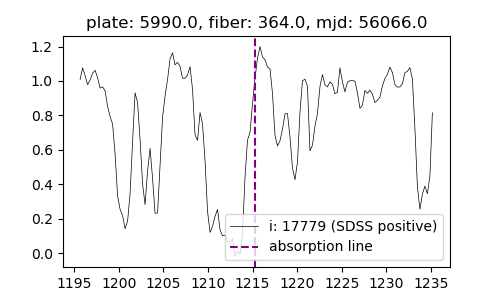

In [15]:
get_spectra_test(10809)